In [139]:
import numpy as np
import pandas as pd 
from scipy import stats
import warnings


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate



import matplotlib.pyplot as plt
import seaborn as sns

import time
start_time = time.time()
%matplotlib inline

In [140]:
# Import the housing dataset as a Pandas Dataframe
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [141]:
# Create a summmary of each column in the df
print(df.info())

print('''
yr_renovated and waterfront are only columns containing null values
''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [142]:
# Set Nan values of 'waterfront' and 'year_renovated' columns to 0
df.loc[df.waterfront.isna()==True, 'waterfront'] = 0
df.loc[df.yr_renovated.isna()==True, 'yr_renovated'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
df.loc[df.sqft_basement=='?', 'sqft_basement'] = 0
df.sqft_basement = df.sqft_basement.astype(float)

# Convert 'date' to a datetime object and use these to create a 'year' column
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)

# Create an 'age' column to specify how old a house was at sale
df['age'] = df['year'] - df['yr_built']

#Drop unnecessary 'id', 'yr_built', 'year', and 'date' columns
cols_to_drop = ['id', 'yr_built', 'year', 'date']
df.drop(cols_to_drop, axis=1, inplace=True)

#Drop rows that contain null values in the 'view' column
df.dropna(subset = ['view'], inplace = True)

#drop the outlier house that contains 33 bedrooms
df = df[df.bedrooms != 33];

There is a relatively normal distribution of bedroom sizes


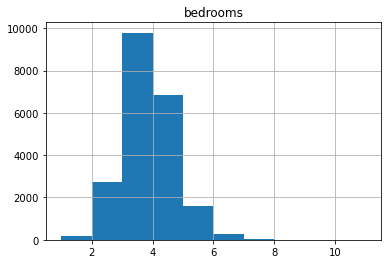

In [143]:
df.hist('bedrooms');
print('There is a relatively normal distribution of bedroom sizes')

Price has a positive skew


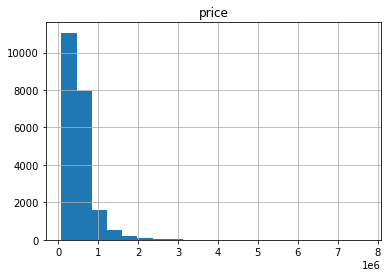

In [144]:
print("Price has a positive skew")
df.hist('price', bins=20);

In [145]:
# Create a matrix of correlations for each feature set in the dataframe
corr_matrix = df.corr()
# Create a boolean mask for all values on or above the matrix diagonal 
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool));

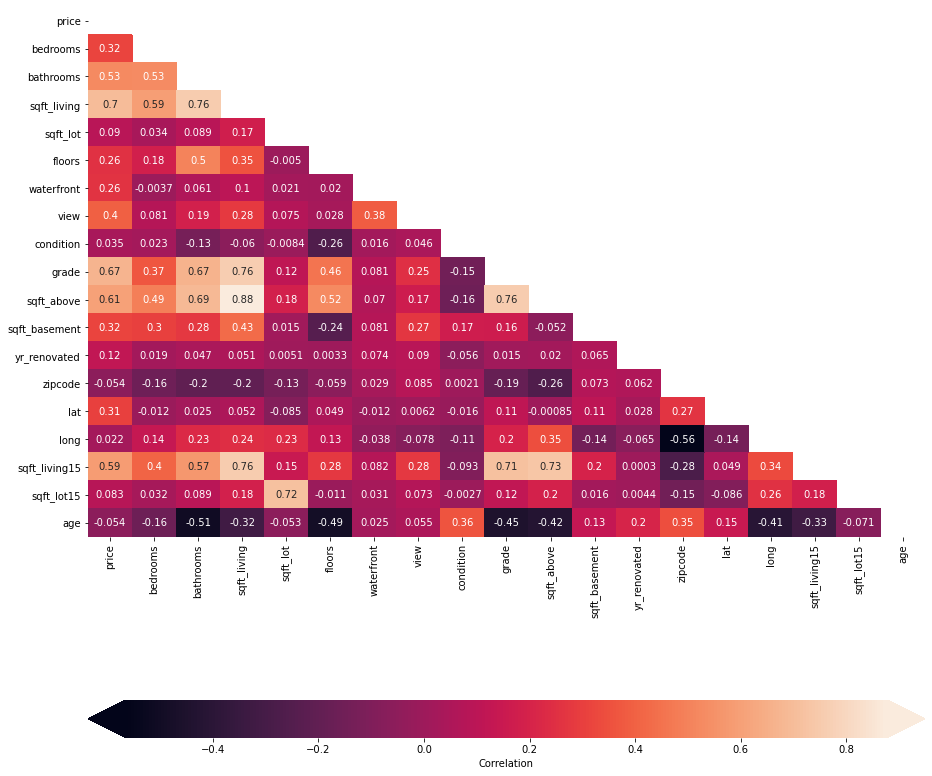

In [146]:
# Creates a heat map of correlation coefficient
fig, ax = plt.subplots(figsize  =(15,15))
sns.heatmap(
            corr_matrix, 
            ax=ax, 
            annot=True, 
            mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

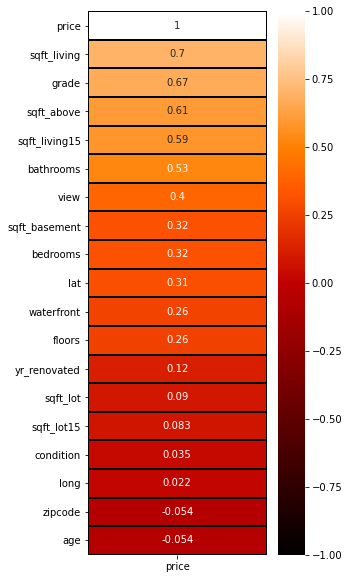

In [147]:
# Price will be our target value to predict, so we'll zero in on its correlations.
plt.figure(figsize=(4,10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, fmt='.2g', cmap="gist_heat")

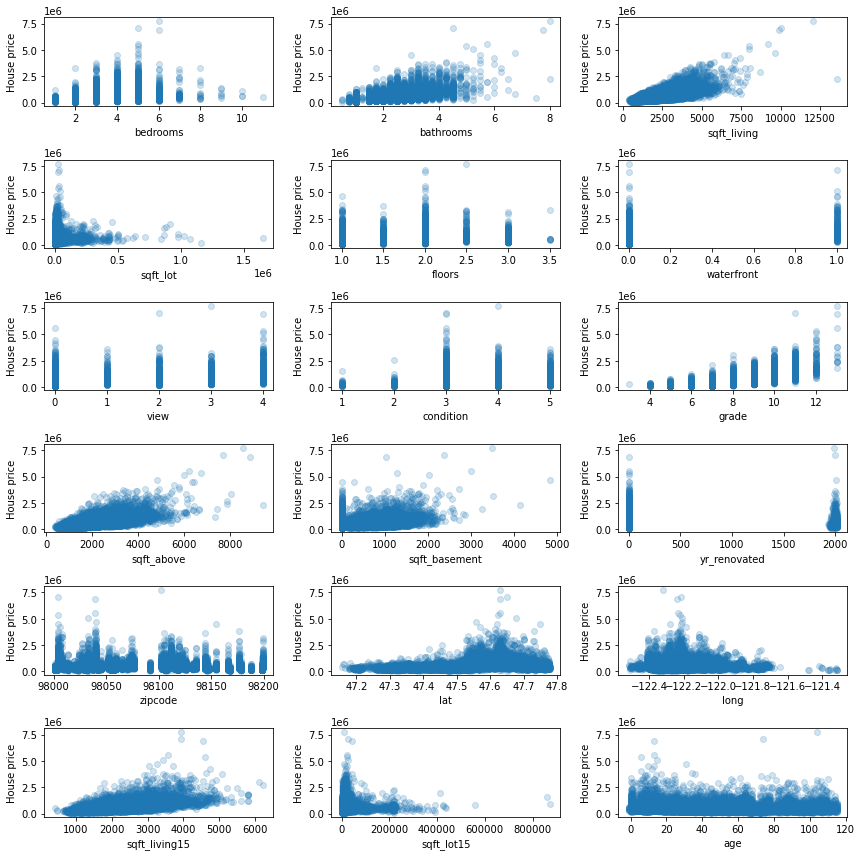

In [148]:
x = df.drop('price', axis=1)
y= df.price
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(12, 12))
fig.set_tight_layout(True)
for index, col in enumerate(x.columns): 
    ax = axes[index//3][index%3]
    ax.scatter(x[col], y, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("House price")

# Model Building

## Baseline Model

In [149]:
# Drop the new 'age' column and our target column 'price' for the indep. features
X = df.drop(['price', 'age'], axis = 1)

# Set our dependent variable as price
y = df.price
  
# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
# Trains our model on our baseline values
lm = LinearRegression().fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)

print(r2_score(y_test, y_predict))

0.6749653844713042


### Model 1:  including 'age'

In [151]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as price
y = df['price']

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [152]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

pred_lr1 = lr.predict(X_test)

train_score_lr1 = lr.score(X_train, y_train)
test_score_lr1 = lr.score(X_test, y_test)

In [153]:
lr.coef_[0]

-37275.512455081895

In [154]:
lr.intercept_

2351046.7488808385

In [155]:
rmse_lr1 = mean_squared_error(y_test, pred_lr1, squared=False)

In [156]:
train_score_lr1, test_score_lr1, rmse_lr1

(0.7026591179673133, 0.6931727130407752, 205731.06771444588)

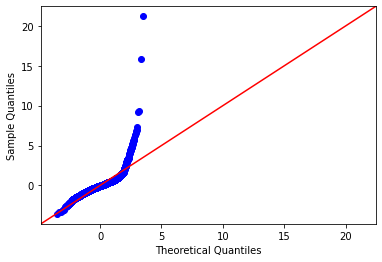

In [157]:
# Checking the QQ Plot
residuals1 = (y_test - pred_lr1)
sm.graphics.qqplot(residuals1, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

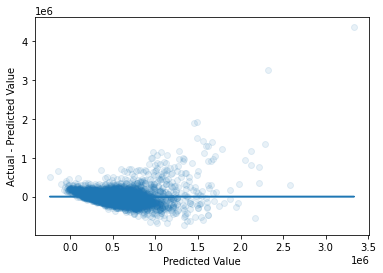

In [158]:
residuals1 = (y_test - pred_lr1)
fig, ax = plt.subplots()
ax.scatter(pred_lr1, residuals1, alpha=.1)
ax.plot(pred_lr1, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

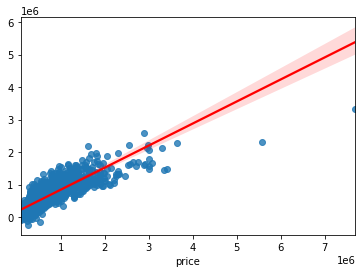

In [159]:
sns.regplot(x = y_test, y = pred_lr1, data = df, line_kws={'color':'r'})

### Model 2: log transform 'price'

In [160]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

pred_lr2 = lr.predict(X_test)

In [162]:
train_score_lr2 = lr.score(X_train, y_train)
test_score_lr2 = lr.score(X_test, y_test)

In [163]:
lr.coef_[0]

-0.013883860421674192

In [164]:
lr.intercept_

-10.50578571317176

In [165]:
rmse_lr2 = mean_squared_error(y_test, pred_lr2, squared=False)

In [166]:
train_score_lr2, test_score_lr2, rmse_lr2

(0.7716633054371127, 0.7649036245277617, 0.25717593403330175)

### Checking the VIF Score

In [167]:
# Making a constant column
df_temp = sm.add_constant(df)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_temp.values, i) for i in range(df_temp.values.shape[1])]
vif["features"] = df_temp.columns

print(vif.round(1))

    VIF Factor       features
0    4432748.0          const
1          3.3          price
2          1.7       bedrooms
3          3.4      bathrooms
4        146.5    sqft_living
5          2.1       sqft_lot
6          2.0         floors
7          1.2     waterfront
8          1.5           view
9          1.2      condition
10         3.7          grade
11       119.0     sqft_above
12        32.9  sqft_basement
13         1.1   yr_renovated
14         1.7        zipcode
15         1.4            lat
16         1.8           long
17         3.0  sqft_living15
18         2.1     sqft_lot15
19         2.5            age


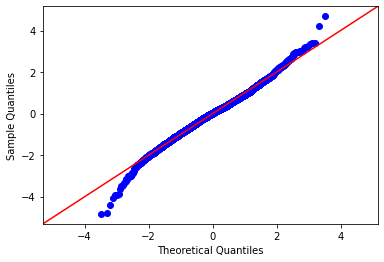

In [168]:
# Making the QQ Plot
residuals2 = (y_test - pred_lr2)
sm.graphics.qqplot(residuals2, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

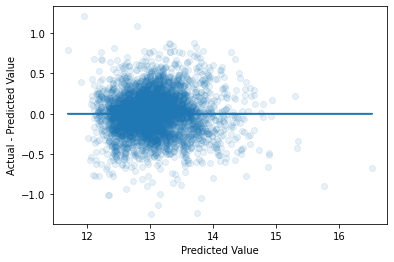

In [169]:
residuals2 = (y_test - pred_lr2)
fig, ax = plt.subplots()
ax.scatter(pred_lr2, residuals2, alpha=.1)
ax.plot(pred_lr2, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

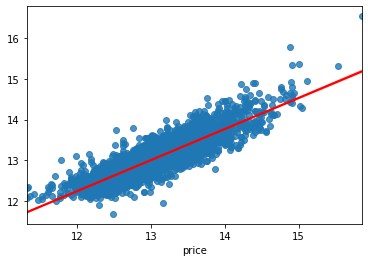

In [170]:
sns.regplot(x = y_test, y = pred_lr2, data = df, line_kws={'color':'r'})

### Model 3:  creating dummy columns for zip code

In [171]:
# Adds dummy zipcode columns
df = df.join(pd.get_dummies(df['zipcode'], prefix = 'x', drop_first = True))

In [172]:
# Drop the dependent variable from the independent columns
X = df.drop(['price'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [173]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [174]:
pred_lr3 = lr.predict(X_test)

In [175]:
train_score_lr3 = lr.score(X_train, y_train)
test_score_lr3 = lr.score(X_test, y_test)

In [176]:
lr.coef_[0]

0.004176496547193397

In [177]:
lr.intercept_

-342.4423582235086

In [178]:
rmse_lr3 = mean_squared_error(y_test, pred_lr3, squared=False)

In [179]:
train_score_lr3, test_score_lr3, rmse_lr3

(0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

In [180]:
# Making an OLS table to check for significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1776.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:23:25   Log-Likelihood:                 5816.2
No. Observations:               21533   AIC:                        -1.146e+04
Df Residuals:                   21446   BIC:                        -1.076e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0227      0.001    -20.735      0.000      -0.025      -0.021
bedrooms          0.0030      0.002      1.596      0.110      -0.001       0.007
bathrooms         0.0416      0.003     13.689      0.000       0.036       0.048
sqft_living       0.0001   1.67e-05      6.625      0.000    7.77e-05       0.000
sqft_lot       6.072e-07   4.43e-08     13.711      0.000     5.2e-07    6.94e-07
floors           -0.0300      0.004     -8.230      0.000      -0.037      -0.023
waterfront        0.4589      0.017     26.977      0.000       0.426       0.492
view              0.0602      0.002     29.985      0.000       0.056       0.064
condition         0.0573      0.002     25.891      0.000       0.053       0.062
grade             0.0936      0.002     44.492      0.000       0.089       0.098
sqft_above     8.705e-05   1.67e-05      5.216      0.000    5.43e-05       0.000
sqft_basement  1.388e-05   1.65e-05      0.842      0.400   -1.84e-05    4.62e-05
yr_renovated   3.939e-05   3.69e-06     10.685      0.000    3.22e-05    4.66e-05
zipcode          -0.0006   7.22e-05     -8.515      0.000      -0.001      -0.000
lat               0.5214      0.073      7.130      0.000       0.378       0.665
long             -0.3815      0.053     -7.264      0.000      -0.484      -0.279
sqft_living15  8.424e-05   3.33e-06     25.282      0.000    7.77e-05    9.08e-05
sqft_lot15     7.774e-08   6.97e-08      1.115      0.265    -5.9e-08    2.14e-07
age               0.0005   7.41e-05      6.544      0.000       0.000       0.001
x_98002          -0.0139      0.017     -0.835      0.404      -0.047       0.019
x_98003          -0.0089      0.015     -0.600      0.549      -0.038       0.020
x_98004           0.9494      0.027     35.077      0.000       0.896       1.002
x_98005           0.5988      0.029     20.700      0.000       0.542       0.655
x_98006           0.5254      0.024     22.197      0.000       0.479       0.572
x_98007           0.5310      0.030     17.791      0.000       0.473       0.590
x_98008           0.5396      0.028     19.024      0.000       0.484       0.595
x_98010           0.3356      0.026     13.043      0.000       0.285       0.386
x_98011           0.2428      0.037      6.604      0.000       0.171       0.315
x_98014           0.2744      0.041      6.730      0.000       0.194       0.354
x_98019           0.2350      0.040      5.863      0.000       0.156       0.314
x_98022           0.2011      0.023      8.663      0.000       0.156       0.247
x_98023          -0.0605      0.013     -4.533      0.000      -0.087      -0.034
x_98024           0.4327      0.036     11.953      0.000       0.362       0.504
x_98027           0.4870      0.025     19.727      0.000       0.439       0.535
x_98028           0.2086      0.035      5.917   

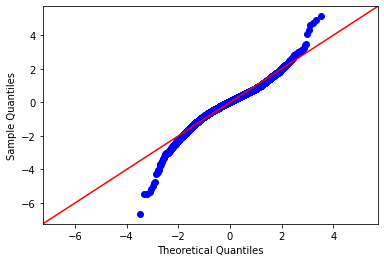

In [181]:
# Making the QQ Plot
residuals3 = (y_test - pred_lr3)
sm.graphics.qqplot(residuals3, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

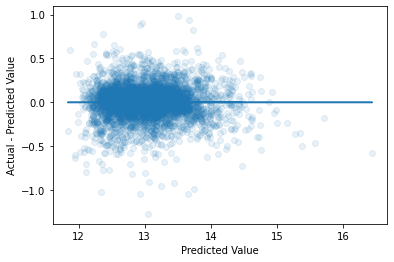

In [182]:
residuals3 = (y_test - pred_lr3)
fig, ax = plt.subplots()
ax.scatter(pred_lr3, residuals3, alpha=.1)
ax.plot(pred_lr3, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

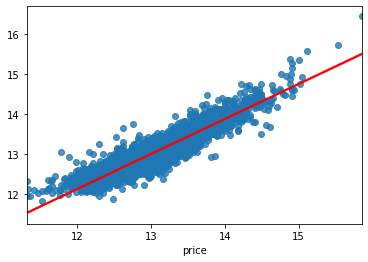

In [183]:
sns.regplot(x = y_test, y = pred_lr3, data = df, line_kws={'color':'r'})

### Model 4:  dropping features with high p_values


In [184]:
# Use summary above to drop features with high p_values
X = df.drop(['price', 'x_98002', 'x_98003', 'sqft_basement', 'sqft_lot15'], axis = 1)

# Set our dependent variable as the natural log of price
y = np.log(df['price'])

# Split up our independent and dependent variables into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [186]:
pred_lr4 = lr.predict(X_test)

In [187]:
train_score_lr4 = lr.score(X_train, y_train)
test_score_lr4 = lr.score(X_test, y_test)

In [188]:
lr.coef_[0]

0.004201930353206344

In [189]:
lr.intercept_

249.51490700648966

In [190]:
rmse_lr4 = mean_squared_error(y_test, pred_lr4, squared=False)

In [191]:
train_score_lr4, test_score_lr4, rmse_lr4

(0.8783495053881852, 0.8702421515098159, 0.19106193728286688)

In [192]:
# Checking the OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1840.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:23:28   Log-Likelihood:                 5815.0
No. Observations:               21533   AIC:                        -1.146e+04
Df Residuals:                   21449   BIC:                        -1.079e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           476.6149    726.953      0.656      0.512    -948.268    1901.497
bedrooms          0.0029      0.002      1.552      0.121      -0.001       0.006
bathrooms         0.0415      0.003     13.660      0.000       0.036       0.047
sqft_living       0.0001   4.11e-06     30.197      0.000       0.000       0.000
sqft_lot       6.397e-07   3.37e-08     18.969      0.000    5.74e-07    7.06e-07
floors           -0.0301      0.004     -8.271      0.000      -0.037      -0.023
waterfront        0.4589      0.017     26.976      0.000       0.426       0.492
view              0.0602      0.002     29.982      0.000       0.056       0.064
condition         0.0573      0.002     25.894      0.000       0.053       0.062
grade             0.0936      0.002     44.524      0.000       0.090       0.098
sqft_above     7.342e-05   4.19e-06     17.515      0.000    6.52e-05    8.16e-05
yr_renovated   3.938e-05   3.69e-06     10.682      0.000    3.22e-05    4.66e-05
zipcode          -0.0055      0.007     -0.739      0.460      -0.020       0.009
lat               0.5219      0.073      7.137      0.000       0.379       0.665
long             -0.3865      0.051     -7.627      0.000      -0.486      -0.287
sqft_living15  8.457e-05   3.32e-06     25.448      0.000    7.81e-05    9.11e-05
age               0.0005   7.41e-05      6.534      0.000       0.000       0.001
x_98004           0.9660      0.030     32.042      0.000       0.907       1.025
x_98005           0.6206      0.036     17.177      0.000       0.550       0.691
x_98006           0.5518      0.038     14.554      0.000       0.478       0.626
x_98007           0.5625      0.048     11.792      0.000       0.469       0.656
x_98008           0.5762      0.053     10.852      0.000       0.472       0.680
x_98010           0.3840      0.066      5.805      0.000       0.254       0.514
x_98011           0.2933      0.076      3.846      0.000       0.144       0.443
x_98014           0.3439      0.100      3.447      0.001       0.148       0.539
x_98019           0.3270      0.134      2.442      0.015       0.065       0.589
x_98022           0.3078      0.152      2.021      0.043       0.009       0.606
x_98023           0.0480      0.157      0.307      0.759      -0.259       0.355
x_98024           0.5506      0.169      3.252      0.001       0.219       0.882
x_98027           0.6170      0.189      3.270      0.001       0.247       0.987
x_98028           0.3416      0.196      1.740      0.082      -0.043       0.726
x_98029           0.7147      0.204      3.503      0.000       0.315       1.115
x_98030           0.2120      0.209      1.012      0.312      -0.199       0.623
x_98031           0.2167      0.217      0.999      0.318      -0.208       0.642
x_98032           0.0942      0.224      0.421   

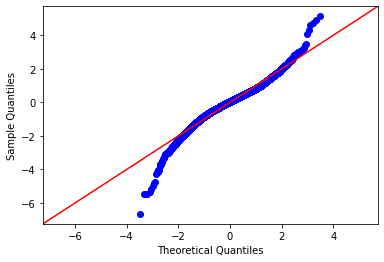

In [193]:
# Making the QQ Plot
residuals4 = (y_test - pred_lr4)
sm.graphics.qqplot(residuals4, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

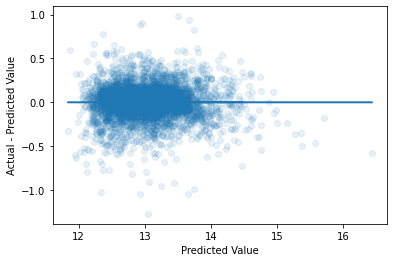

In [194]:
residuals4 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr4, residuals4, alpha=.1)
ax.plot(pred_lr4, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

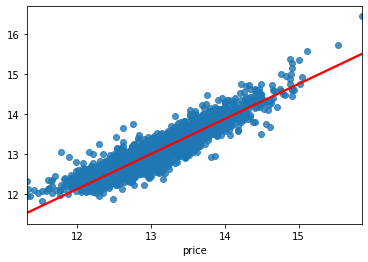

In [195]:
sns.regplot(x = y_test, y = pred_lr4, data = df, line_kws={'color':'r'})

### Model 5: adding back the zipcodes we dropped in our previous model

In [196]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [198]:
pred_lr5 = lr.predict(X_test)

In [199]:
train_score_lr5 = lr.score(X_train, y_train)
test_score_lr5 = lr.score(X_test, y_test)

In [200]:
lr.coef_[0]

0.004208604780889794

In [201]:
lr.intercept_

-342.26705920133645

In [202]:
rmse_lr5 = mean_squared_error(y_test, pred_lr5, squared=False)

In [203]:
train_score_lr5, test_score_lr5, rmse_lr5

(0.8783558959432097, 0.8702225186552952, 0.1910763909339751)

In [204]:
# Checking the OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1818.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:23:30   Log-Likelihood:                 5815.2
No. Observations:               21533   AIC:                        -1.146e+04
Df Residuals:                   21448   BIC:                        -1.078e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0226      0.001    -20.709      0.000      -0.025      -0.021
bedrooms          0.0029      0.002      1.555      0.120      -0.001       0.007
bathrooms         0.0415      0.003     13.665      0.000       0.036       0.047
sqft_living       0.0001   4.11e-06     30.194      0.000       0.000       0.000
sqft_lot       6.391e-07   3.37e-08     18.948      0.000    5.73e-07    7.05e-07
floors           -0.0301      0.004     -8.258      0.000      -0.037      -0.023
waterfront        0.4590      0.017     26.981      0.000       0.426       0.492
view              0.0602      0.002     29.985      0.000       0.056       0.064
condition         0.0573      0.002     25.898      0.000       0.053       0.062
grade             0.0936      0.002     44.478      0.000       0.089       0.098
sqft_above     7.347e-05   4.19e-06     17.523      0.000    6.53e-05    8.17e-05
yr_renovated   3.939e-05   3.69e-06     10.684      0.000    3.22e-05    4.66e-05
zipcode          -0.0006   7.21e-05     -8.472      0.000      -0.001      -0.000
lat               0.5221      0.073      7.140      0.000       0.379       0.665
long             -0.3782      0.052     -7.211      0.000      -0.481      -0.275
sqft_living15  8.451e-05   3.33e-06     25.415      0.000     7.8e-05     9.1e-05
age               0.0005   7.41e-05      6.542      0.000       0.000       0.001
x_98002          -0.0141      0.017     -0.845      0.398      -0.047       0.019
x_98003          -0.0089      0.015     -0.596      0.551      -0.038       0.020
x_98004           0.9490      0.027     35.064      0.000       0.896       1.002
x_98005           0.5983      0.029     20.686      0.000       0.542       0.655
x_98006           0.5246      0.024     22.169      0.000       0.478       0.571
x_98007           0.5303      0.030     17.769      0.000       0.472       0.589
x_98008           0.5388      0.028     19.002      0.000       0.483       0.594
x_98010           0.3360      0.026     13.063      0.000       0.286       0.386
x_98011           0.2421      0.037      6.586      0.000       0.170       0.314
x_98014           0.2751      0.041      6.750      0.000       0.195       0.355
x_98019           0.2347      0.040      5.857      0.000       0.156       0.313
x_98022           0.2013      0.023      8.676      0.000       0.156       0.247
x_98023          -0.0603      0.013     -4.520      0.000      -0.086      -0.034
x_98024           0.4336      0.036     11.982      0.000       0.363       0.504
x_98027           0.4865      0.025     19.710      0.000       0.438       0.535
x_98028           0.2079      0.035      5.897      0.000       0.139       0.277
x_98029           0.5742      0.028     20.399      0.000       0.519       0.629
x_98030           0.0681      0.017      4.061   

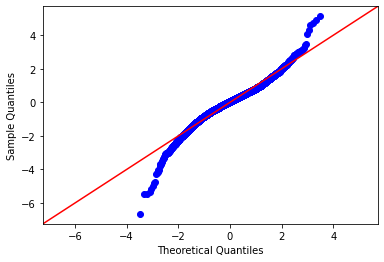

In [205]:
residuals5 = (y_test - pred_lr5)
sm.graphics.qqplot(residuals5, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

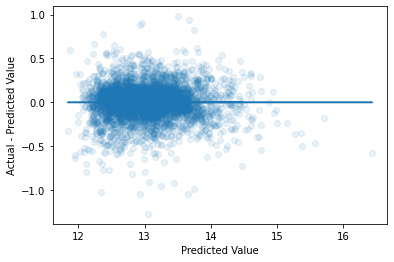

In [206]:
residuals5 = (y_test - pred_lr4)
fig, ax = plt.subplots()
ax.scatter(pred_lr5, residuals5, alpha=.1)
ax.plot(pred_lr5, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

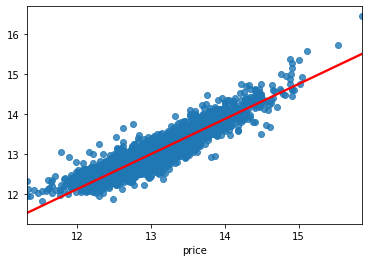

In [207]:
sns.regplot(x = y_test, y = pred_lr5, data = df, line_kws={'color':'r'})

### Model 6: Our best LR model

In [208]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [211]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr6 = lr.predict(X_test)

train_score_lr6 = lr.score(X_train, y_train)
test_score_lr6 = lr.score(X_test, y_test)

lr.coef_[0]
lr.intercept_
rmse_lr6 = mean_squared_error(y_test, pred_lr6, squared=False)

In [212]:
train_score_lr6, test_score_lr6, rmse_lr6

(0.8765432246064853, 0.8686285930439092, 0.19224620904784312)

In [213]:
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     1810.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:24:09   Log-Likelihood:                 5662.2
No. Observations:               21533   AIC:                        -1.116e+04
Df Residuals:                   21449   BIC:                        -1.049e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0218      0.001    -19.819      0.000      -0.024      -0.020
bedrooms          0.0021      0.002      1.119      0.263      -0.002       0.006
bathrooms         0.0349      0.003     11.486      0.000       0.029       0.041
sqft_living       0.0002   3.17e-06     53.832      0.000       0.000       0.000
sqft_lot        6.61e-07   3.39e-08     19.470      0.000    5.94e-07    7.28e-07
floors            0.0006      0.003      0.181      0.857      -0.006       0.007
waterfront        0.4618      0.017     26.958      0.000       0.428       0.495
view              0.0549      0.002     27.477      0.000       0.051       0.059
condition         0.0538      0.002     24.221      0.000       0.049       0.058
grade             0.1006      0.002     48.320      0.000       0.096       0.105
yr_renovated   3.758e-05   3.71e-06     10.124      0.000    3.03e-05    4.49e-05
zipcode          -0.0006   7.26e-05     -7.932      0.000      -0.001      -0.000
lat               0.5170      0.074      7.020      0.000       0.373       0.661
long             -0.3516      0.053     -6.661      0.000      -0.455      -0.248
sqft_living15  9.106e-05   3.33e-06     27.367      0.000    8.45e-05    9.76e-05
age               0.0006   7.41e-05      8.597      0.000       0.000       0.001
x_98002          -0.0103      0.017     -0.613      0.540      -0.043       0.023
x_98003          -0.0115      0.015     -0.766      0.443      -0.041       0.018
x_98004           0.9423      0.027     34.573      0.000       0.889       0.996
x_98005           0.5881      0.029     20.194      0.000       0.531       0.645
x_98006           0.5091      0.024     21.378      0.000       0.462       0.556
x_98007           0.5218      0.030     17.364      0.000       0.463       0.581
x_98008           0.5302      0.029     18.568      0.000       0.474       0.586
x_98010           0.3345      0.026     12.911      0.000       0.284       0.385
x_98011           0.2361      0.037      6.377      0.000       0.164       0.309
x_98014           0.2688      0.041      6.549      0.000       0.188       0.349
x_98019           0.2277      0.040      5.643      0.000       0.149       0.307
x_98022           0.2011      0.023      8.606      0.000       0.155       0.247
x_98023          -0.0631      0.013     -4.696      0.000      -0.089      -0.037
x_98024           0.4323      0.036     11.864      0.000       0.361       0.504
x_98027           0.4680      0.025     18.844      0.000       0.419       0.517
x_98028           0.1997      0.035      5.627      0.000       0.130       0.269
x_98029           0.5622      0.028     19.839      0.000       0.507       0.618
x_98030           0.0658      0.017      3.897      0.000       0.033       0.099
x_98031           0.0623      0.017      3.574   

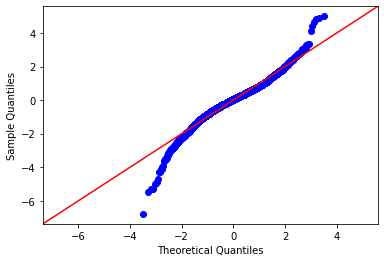

In [215]:
# Making the QQ Plot
residuals6 = (y_test - pred_lr6)
sm.graphics.qqplot(residuals6, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

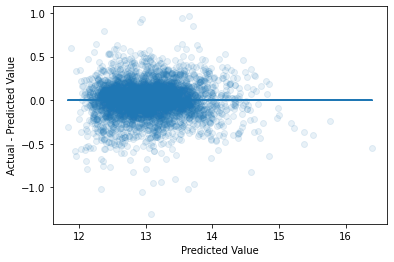

In [216]:
residuals6 = (y_test - pred_lr6)
fig, ax = plt.subplots()
ax.scatter(pred_lr6, residuals6, alpha=.1)
ax.plot(pred_lr6, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

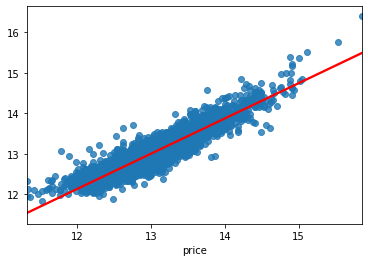

In [217]:
sns.regplot(x = y_test, y = pred_lr6, data = df, line_kws={'color':'r'})

### Model 7: Feature Engineering

In [218]:
# Feature Engineering Making 4 new colmns
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [219]:
# Droping columns that are not going to be used
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [220]:
# Initialize an empty regression model
lr = LinearRegression()

# Fits the model to our training dataset
lr.fit(X_train, y_train)

LinearRegression()

In [221]:
pred_lr7 = lr.predict(X_test)

In [222]:
train_score_lr7 = lr.score(X_train, y_train)
test_score_lr7 = lr.score(X_test, y_test)

In [223]:
lr.coef_[0]

0.03313124920941296

In [224]:
lr.intercept_

-347.43229285616803

In [225]:
rmse_lr7 = mean_squared_error(y_test, pred_lr7, squared=False)

In [226]:
train_score_lr7, test_score_lr7, rmse_lr7

(0.8571154620484464, 0.8450870182567047, 0.20876191193343574)

In [227]:
# Checking OLS for values of significance
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     1503.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:24:35   Log-Likelihood:                 4044.5
No. Observations:               21533   AIC:                            -7919.
Df Residuals:                   21448   BIC:                            -7241.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0232      0.001    -19.550      0.000      -0.026      -0.021
bedrooms                0.0330      0.002     17.521      0.000       0.029       0.037
sqft_lot             6.961e-07   3.68e-08     18.939      0.000    6.24e-07    7.68e-07
floors                  0.0013      0.004      0.346      0.729      -0.006       0.009
waterfront              0.4534      0.018     24.536      0.000       0.417       0.490
view                    0.0658      0.002     29.962      0.000       0.061       0.070
condition               0.0670      0.002     27.979      0.000       0.062       0.072
yr_renovated         5.812e-05   3.99e-06     14.575      0.000    5.03e-05    6.59e-05
zipcode                -0.0007   7.83e-05     -8.509      0.000      -0.001      -0.001
lat                     0.5661      0.079      7.130      0.000       0.410       0.722
long                   -0.4096      0.057     -7.194      0.000      -0.521      -0.298
sqft_living15           0.0003    6.2e-06     41.466      0.000       0.000       0.000
age                    -0.0004    7.7e-05     -4.943      0.000      -0.001      -0.000
x_98002                -0.0235      0.018     -1.294      0.196      -0.059       0.012
x_98003                 0.0059      0.016      0.368      0.713      -0.026       0.038
x_98004                 0.9473      0.029     32.239      0.000       0.890       1.005
x_98005                 0.6270      0.031     19.976      0.000       0.565       0.689
x_98006                 0.5399      0.026     21.016      0.000       0.490       0.590
x_98007                 0.5433      0.032     16.775      0.000       0.480       0.607
x_98008                 0.5491      0.031     17.837      0.000       0.489       0.609
x_98010                 0.3312      0.028     11.858      0.000       0.276       0.386
x_98011                 0.2337      0.040      5.855      0.000       0.155       0.312
x_98014                 0.2643      0.044      5.973      0.000       0.178       0.351
x_98019                 0.2176      0.044      5.000      0.000       0.132       0.303
x_98022                 0.2101      0.025      8.338      0.000       0.161       0.259
x_98023                -0.0518      0.014     -3.577      0.000      -0.080      -0.023
x_98024                 0.4330      0.039     11.021      0.000       0.356       0.510
x_98027                 0.4914      0.027     18.342      0.000       0.439       0.544
x_98028                 0.2002      0.038      5.231      0.000       0.125       0.275
x_98029                 0.5919      0.031     19.377      0.000       0.532       0.652
x_98030                 0.0681      0.018      3.742      0.000       0.032       0.104
x_98031                 0.0623      0.019      3.313      0.001       0.025       0.099
x_9

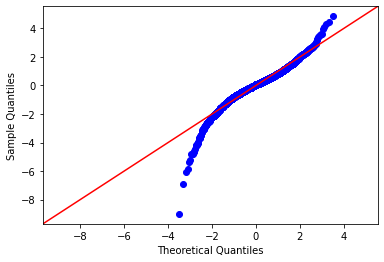

In [228]:
residuals7 = (y_test - pred_lr7)
sm.graphics.qqplot(residuals7, dist=stats.norm, line="45", fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

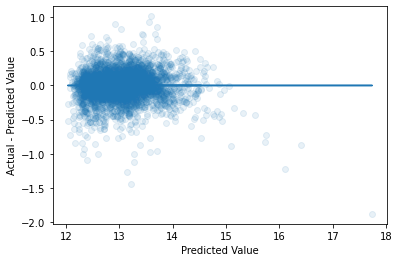

In [229]:
residuals7 = (y_test - pred_lr7)
fig, ax = plt.subplots()
ax.scatter(pred_lr7, residuals7, alpha=.1)
ax.plot(pred_lr7, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

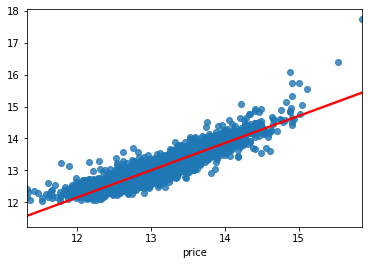

In [230]:
sns.regplot(x = y_test, y = pred_lr7, data = df, line_kws={'color':'r'})

### Model 8: A Polynomial model

In [105]:
df['grade_sqft_living'] = (df.grade**2) * df.sqft_living
df['grade_sqft_above'] = (df.grade**2) * df.sqft_above
df['grade_sqft_living15'] = (df.grade**2) * df.sqft_living15
df['grade_bathrooms'] = (df.grade**2) * df.bathrooms

In [106]:
X = df.drop(['price', 'sqft_basement', 'sqft_lot15', 'sqft_above', 'bathrooms', 'sqft_living', 'grade'], axis = 1)
y = df['price'] 
# y = np.log(y)

# ss = StandardScaler()
# X = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
poly = PolynomialFeatures(2)

In [108]:
X_train_poly = poly.fit_transform(X_train)

In [109]:
X_test_poly = poly.transform(X_test)

In [110]:
lr = LinearRegression()

In [111]:
lr.fit(X_train_poly, y_train)

LinearRegression()

In [112]:
score_train_poly = lr.score(X_train_poly, y_train)

In [113]:
score_test_poly = lr.score(X_test_poly,y_test)

In [114]:
pred_poly = lr.predict(X_test_poly)

In [115]:
rmse_poly = mean_squared_error(y_test, pred_poly, squared=False)

In [116]:
score_train_poly, score_test_poly, rmse_poly

(0.9311304132469491, 0.8807643708530817, 128249.56887121135)

In [117]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train)

model_1 = LinearRegression()

scores_simple = cross_validate(
                    model_1, X_poly, y_train, cv=5, 
                    return_train_score=True
)
scores_simple

{'fit_time': array([31.79106712, 30.29490209, 29.75348139, 33.41077495, 52.40359998]),
 'score_time': array([0.08405995, 0.0212009 , 0.0296948 , 0.0220952 , 0.01534414]),
 'test_score': array([0.88036806, 0.89342676, 0.88573965, 0.89674191, 0.87937184]),
 'train_score': array([0.93326923, 0.93449446, 0.93289861, 0.93265429, 0.93634745])}

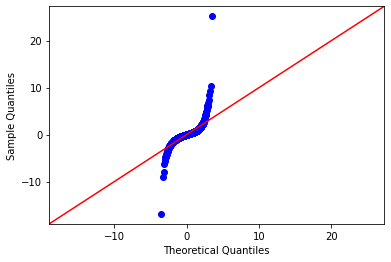

In [118]:
residuals = (y_test - pred_poly)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

Text(0, 0.5, 'Actual - Predicted Value')

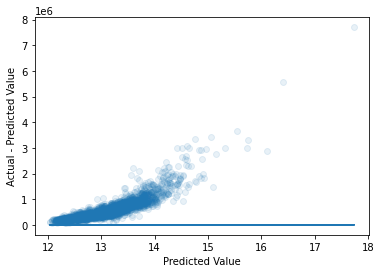

In [119]:
residuals = (y_test - pred_lr)
fig, ax = plt.subplots()
ax.scatter(pred_lr, residuals, alpha=.1)
ax.plot(pred_lr, [0 for i in range(len(X_test))])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual - Predicted Value')

<AxesSubplot:xlabel='price'>

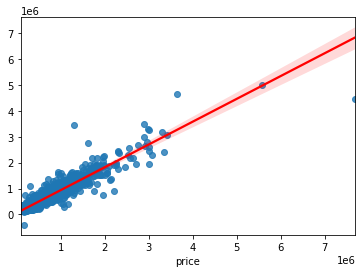

In [138]:
sns.regplot(x = y_test, y = pred_poly, data = df, line_kws={'color':'r'})

In [120]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 364.05656599998474 seconds ---
